In [14]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Function to preprocess images
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Data generator class
class ImageDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=32, target_size=(128, 128), shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        images = [load_and_preprocess_image(path, self.target_size) for path in batch_image_paths]
        if isinstance(batch_labels[0], str):  # For restoration task where labels are image paths
            labels = [load_and_preprocess_image(path, self.target_size) for path in batch_labels]
            return np.array(images), np.array(labels)
        return np.array(images), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            self.image_paths, self.labels = self._shuffle_data(self.image_paths, self.labels)

    def _shuffle_data(self, image_paths, labels):
        indices = np.arange(len(image_paths))
        np.random.shuffle(indices)
        return image_paths[indices], labels[indices]

# Load the dataset
csv_file = r'D:\Intel\project_01\Ferrari_dataset.csv'
data = pd.read_csv(csv_file)

# Display sample data
print("Sample data:")
print(data.head())


Sample data:
   image_number                                         image_path  label
0             0   D:\Intel\project_01\data\Ferrari\Ferrari_000.jpg      1
1             0  D:\Intel\project_01\data\Ferrari_pixelated\pix...      0
2             1   D:\Intel\project_01\data\Ferrari\Ferrari_001.jpg      1
3             1  D:\Intel\project_01\data\Ferrari_pixelated\pix...      0
4             2   D:\Intel\project_01\data\Ferrari\Ferrari_002.jpg      1


c:\Users\yasha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


c:\Users\yasha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 416ms/step - accuracy: 0.4917 - loss: 1.3682 - val_accuracy: 0.5312 - val_loss: 0.8614
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - accuracy: 0.4990 - loss: 0.7874 - val_accuracy: 0.4688 - val_loss: 0.7554
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - accuracy: 0.5250 - loss: 0.6990 - val_accuracy: 0.4688 - val_loss: 0.7113
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - accuracy: 0.5552 - loss: 0.6778 - val_accuracy: 0.4688 - val_loss: 0.7187
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step - accuracy: 0.6573 - loss: 0.6720 - val_accuracy: 0.3125 - val_loss: 0.7315
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - accuracy: 0.7427 - loss: 0.6427 - val_accuracy: 0.3125 - val_loss: 0.7780
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 331ms/step - accuracy: 0.6615 - loss: 0.6420 - val_accuracy: 0.3125 - val_loss: 0.8094
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step - accuracy: 0.7385 - loss: 0.6069 - val_accuracy: 0.3438 - val_loss: 0.8159
Epo

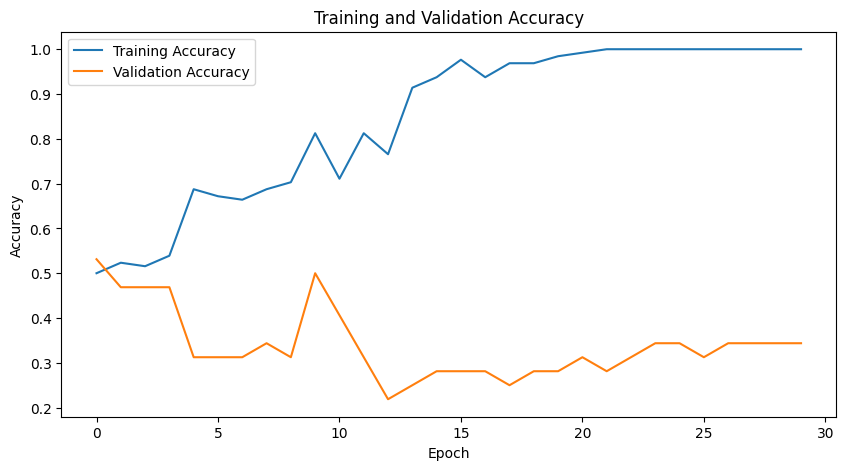

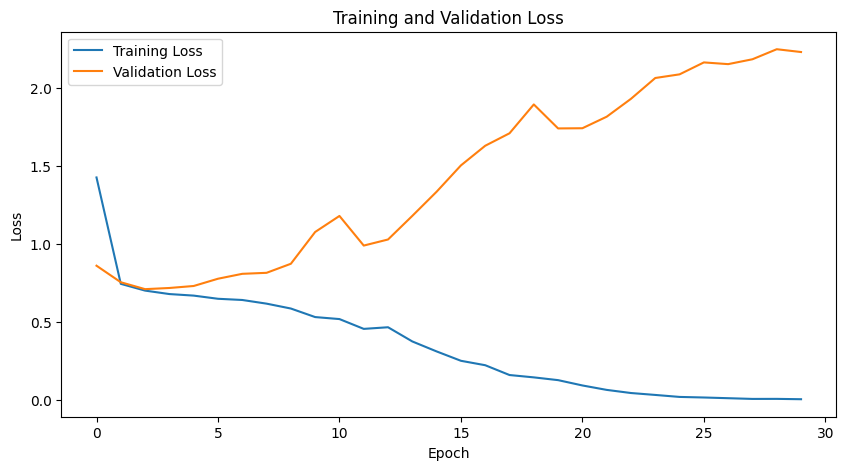

In [33]:
# Part 1: Detecting Pixelation in Images

# Split dataset
train_data = data.sample(frac=0.8, random_state=122)
val_data = data.drop(train_data.index)

# Create data generators for pixelation detection
train_generator = ImageDataGenerator(train_data['image_path'].values, train_data['label'].values, batch_size=32)
val_generator = ImageDataGenerator(val_data['image_path'].values, val_data['label'].values, batch_size=32, shuffle=False)

# Define the pixelation detection model
modell= Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

modell.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the pixelation detection model
history=modell.fit(train_generator, epochs=30, validation_data=val_generator)

# Display training history
print("Training history:")
print(history.history)

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [16]:
# Part 2: Restoring Pixelated Images

# Separate pixelated and original images
pixelated_data = data[data['label'] == 0]
original_data = data[data['label'] == 1]

# Ensure the same image numbers are paired
paired_data = pixelated_data.merge(original_data, on='image_number', suffixes=('_pixelated', '_original'))

# Create data generators for image restoration
restoration_train_data = paired_data.sample(frac=0.8, random_state=42)
restoration_val_data = paired_data.drop(restoration_train_data.index)

restoration_train_generator = ImageDataGenerator(
    restoration_train_data['image_path_pixelated'].values,
    restoration_train_data['image_path_original'].values,
    batch_size=16
)

restoration_val_generator = ImageDataGenerator(
    restoration_val_data['image_path_pixelated'].values,
    restoration_val_data['image_path_original'].values,
    batch_size=16,
    shuffle=False
)

# Display the number of samples in each set
print(f"Number of training samples for restoration: {len(restoration_train_data)}")
print(f"Number of validation samples for restoration: {len(restoration_val_data)}")

Number of training samples for restoration: 78
Number of validation samples for restoration: 20


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet(input_size=(128, 128, 3)):
    # Define the input layer
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = UpSampling2D((2, 2))(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D((2, 2))(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D((2, 2))(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D((2, 2))(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    # Output layer
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create an instance of the U-Net model with the original input size (128x128)
model = unet()

# Compile the model with an optimizer, loss function, and metrics
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


Epoch 1/10


c:\Users\yasha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 10s/step - accuracy: 0.3798 - loss: 0.0893 - val_accuracy: 0.7123 - val_loss: 0.1438
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 9s/step - accuracy: 0.5774 - loss: 0.1116 - val_accuracy: 0.7123 - val_loss: 0.0852
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 9s/step - accuracy: 0.6070 - loss: 0.0830 - val_accuracy: 0.7121 - val_loss: 0.0699
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 9s/step - accuracy: 0.5451 - loss: 0.0787 - val_accuracy: 0.6512 - val_loss: 0.0723
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 9s/step - accuracy: 0.5792 - loss: 0.0687 - val_accuracy: 0.6307 - val_loss: 0.0435
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 11s/step - accuracy: 0.5462 - loss: 0.0355 - val_accuracy: 0.5677 - val_loss: 0.0355
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 12s/step - accuracy: 0.5150 - loss: 0.0308 - val_accuracy: 0.6489 - val_loss: 0.0316
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.5946 - loss: 0.0246 - val_accuracy: 0.4916 - val_loss: 0.0242
Epoch 9/10
4/4 ━

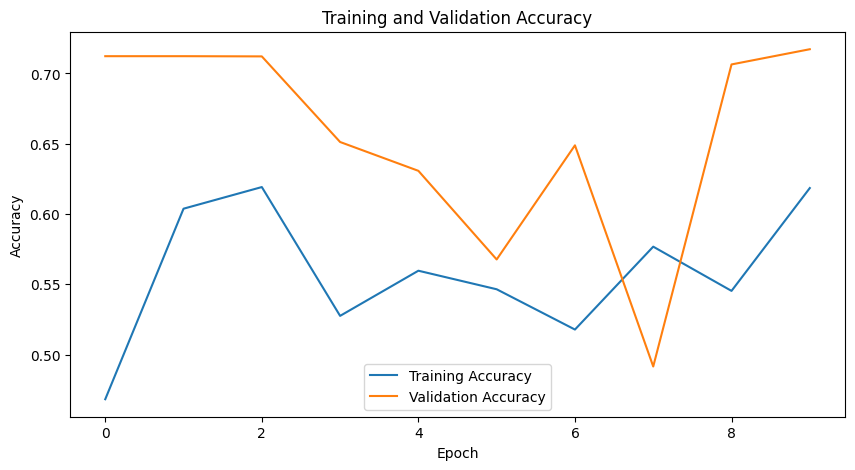

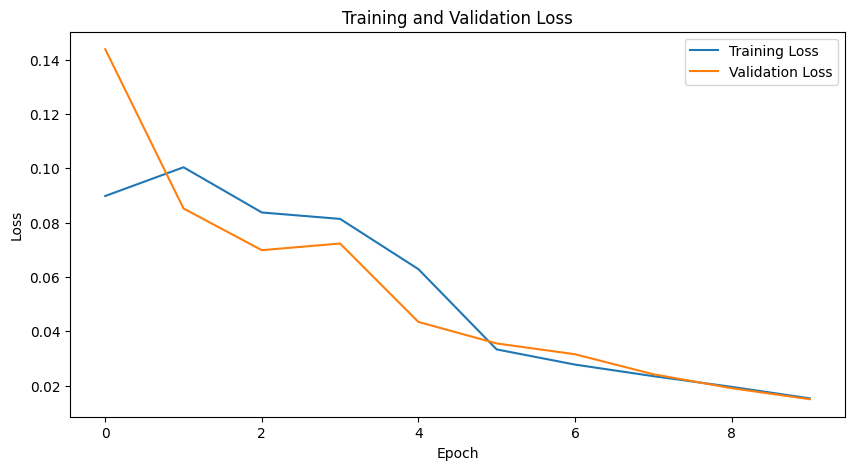

In [18]:

# Train the image restoration model
history=model.fit(restoration_train_generator, epochs=10, validation_data=restoration_val_generator)
#history = model.fit(restoration_train_generator, epochs=10, validation_data=restoration_val_generator)

# Display training history
print("Restoration training history:")
print(history.history)
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


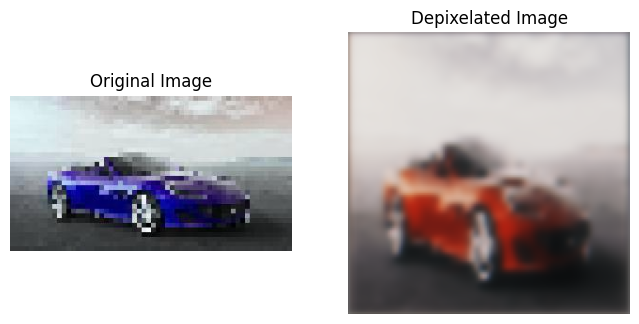

In [19]:


import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# Function to load and preprocess a single image
def load_and_preprocess_single_image(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Function to detect if an image is pixelated
def detect_pixelation(model, image_path, threshold=0.5):
    img = load_and_preprocess_single_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    if prediction >= threshold:
        return False
    else:
        return True

# Function to depixelate an image using the restoration model
def depixelate_image(model, image_path):
    img = load_and_preprocess_single_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    depixelated_img = model.predict(img)
    return depixelated_img[0]  # Remove batch dimension

# Function to process an image, detect pixelation, and depixelate if necessary
def process_image(image_path, pixelation_model, restoration_model):
    if detect_pixelation(pixelation_model, image_path):
        depixelated_img = depixelate_image(restoration_model, image_path)
        depixelated_img = np.clip(depixelated_img, 0, 1)  # Clip values to [0, 1]
        depixelated_img = depixelated_img.astype(np.float32)  # Ensure correct data type

        # Display the images
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(cv2.imread(image_path))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Depixelated Image')
        plt.imshow(depixelated_img)
        plt.axis('off')

        plt.show()
    else:
        plt.figure(figsize=(4, 4))
        plt.title('Non-Pixelated Image')
        plt.imshow(cv2.imread(image_path))
        plt.axis('off')
        plt.show()

# Example usage
if __name__ == "__main__":
    # Load models
    #pixelation_model = load_model('pixelation_detection_model.h5')  # Replace with actual model path
    #restoration_model = load_model('unet_restoration_model.h5')  # Replace with actual model path
    
    # Replace with path to your test image
    ##image_path = r'D:\Intel\project_01\data\Ferrari_pixelated\pixelated_Ferrari_003.jpg'
    #process_image(image_path, pixelation_model, restoration_model)
    # Example usage
    image_path = r'D:\Intel\project_01\data\Ferrari_pixelated\pixelated_Ferrari_003.jpg'  # Replace with path to your test image
    process_image(image_path,modell,model)




In [31]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Function to load and preprocess a single image
def load_and_preprocess_single_image(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Function to depixelate an image using the restoration model
def depixelate_image(model, img, target_size=(128, 128)):
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    depixelated_img = model.predict(img)
    depixelated_img = np.clip(depixelated_img, 0, 1)  # Clip values to [0, 1]
    depixelated_img = cv2.resize(depixelated_img[0], (target_size[1], target_size[0]))  # Resize to target size
    return depixelated_img

# Function to process an image, detect pixelation, and depixelate if necessary
def process_image(image_path, pixelation_model, restoration_model, target_size=(256, 256)):
    
    img = load_and_preprocess_single_image(image_path, target_size)
    depixelated_img = depixelate_image(restoration_model, img, target_size)

    # Plotting images using matplotlib
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(depixelated_img)
    axes[1].set_title('Depixelated Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()



In [53]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Function to load and preprocess a single image
def load_and_preprocess_single_image(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Function to depixelate an image using the restoration model
def depixelate_image(model, img, target_size=(128, 128)):
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    depixelated_img = model.predict(img)
    depixelated_img = np.clip(depixelated_img, 0, 1)  # Clip values to [0, 1]
    depixelated_img = cv2.resize(depixelated_img[0], (target_size[1], target_size[0]))  # Resize to target size
    return depixelated_img

# Function to detect pixelation in an image
def detect_pixelation(model, image_path, target_size=(128, 128)):
    img = load_and_preprocess_single_image(image_path, target_size)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    return prediction[0][0]  # Assuming the model outputs a single scalar value

# Function to process an image, detect pixelation, and depixelate if necessary
def process_image(image_path, pixelation_model, restoration_model, target_size=(256, 256)):
    img = load_and_preprocess_single_image(image_path, target_size)
    print(detect_pixelation(pixelation_model, image_path))
    if detect_pixelation(pixelation_model, image_path) <0.02:
        depixelated_img = depixelate_image(restoration_model, img, target_size)

        # Plotting images using matplotlib
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(img)
        axes[0].set_title('Pixelated Image')
        axes[0].axis('off')

        axes[1].imshow(depixelated_img)
        axes[1].set_title('Depixelated Image')
        axes[1].axis('off')

    else:
        fig, axes = plt.subplots(1, 2, figsize=(6, 6))
        axes[0].imshow(img)
        axes[0].set_title('The Image is Not Pixelated')
        axes[0].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
# pixelation_model = load_model('path_to_pixelation_model.h5')
# restoration_model = load_model('path_to_restoration_model.h5')
# process_image('path_to_image.jpg', pixelation_model, restoration_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0.01930157
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


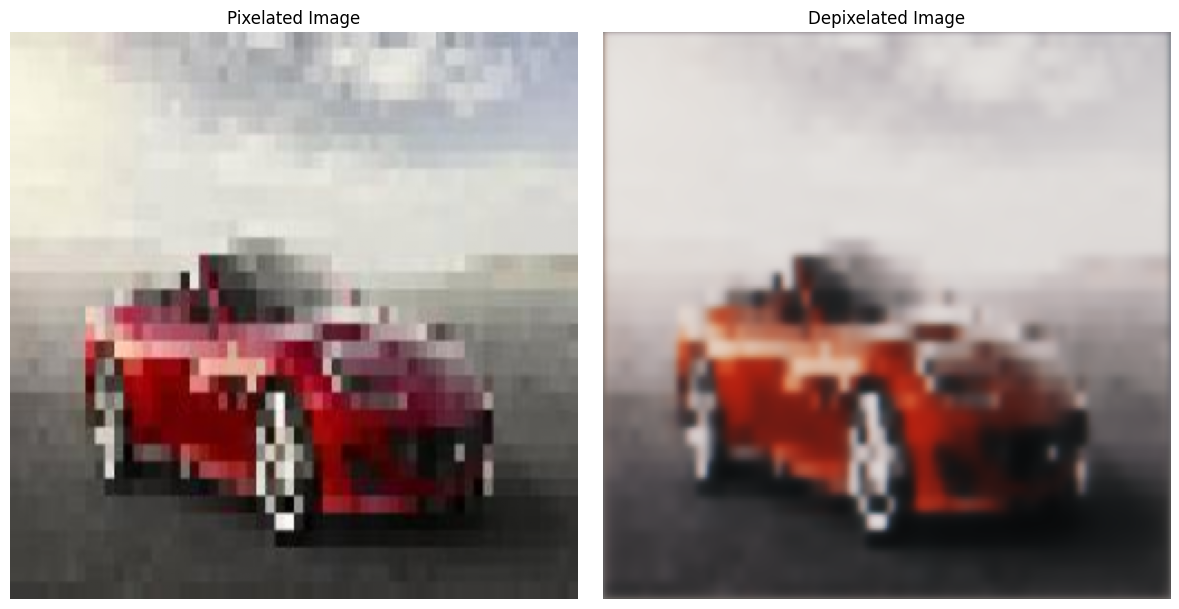

In [54]:
image_path = r'D:\Intel\project_01\data\Ferrari_pixelated\pixelated_Ferrari_003.jpg'  # Replace with path to your test image
process_image(image_path,modell,model)

In [22]:
#image_path = r'C:\Users\yasha\Downloads\output-onlinetools.png'  # Replace with path to your test image
#process_image(image_path,modell,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.057987753
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


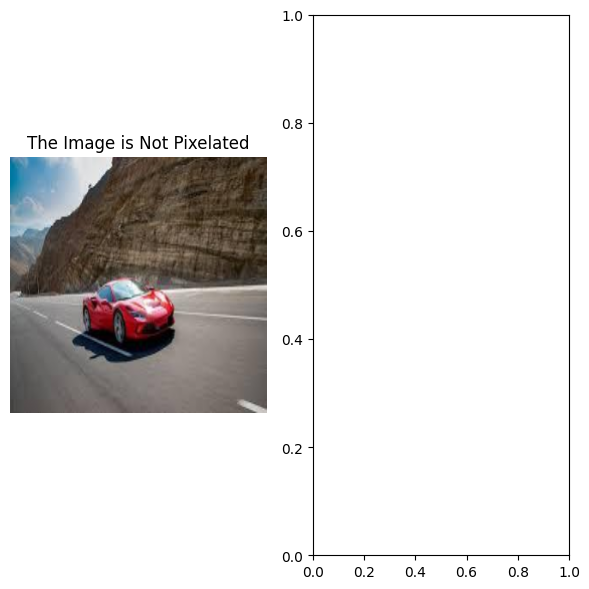

In [51]:
image_path = r'D:\Intel\project_01\data\Ferrari\Ferrari_024.jpg'  # Replace with path to your test image
process_image(image_path,modell,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0.9859818
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


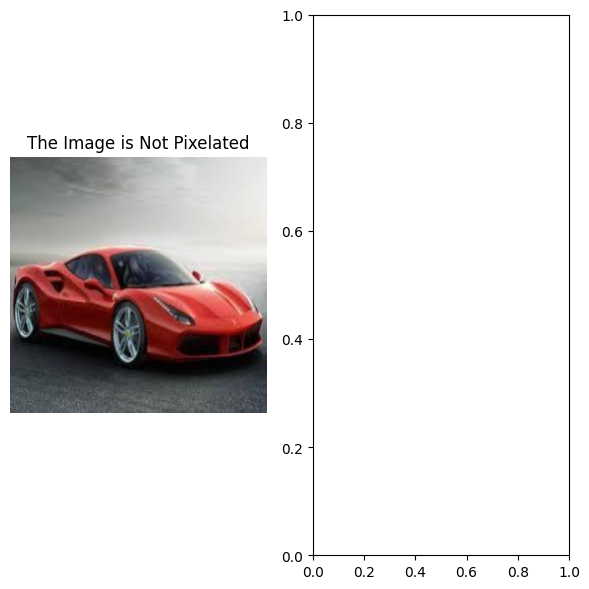

In [52]:
image_path = r'D:\Intel\project_01\data\Ferrari\Ferrari_017.jpg'  # Replace with path to your test image
process_image(image_path,modell,model)